![alt text](https://bdaaosu.org/img/Logo.png)

# <center> Intro to Text Analytics with Python </center>

---



## Importing packages / downloading stuff

Packages are the backbone of Python. We'll need a couple very popular packages for our task, so let's install them and load them in.

In [0]:
import nltk
from nltk.tokenize import word_tokenize # Word tokenizer
from nltk.probability import FreqDist # Fistribution generator for token frequency
from nltk.corpus import stopwords # Stopwords
from nltk.stem.wordnet import WordNetLemmatizer # Lemmatizer using NLTK's "wordnet"
from nltk.stem.porter import PorterStemmer # Word stemmer
import gensim # LDA topic modeling
import pandas as pd # Data manipulation package; keystone python data science package
import matplotlib.pyplot as plt # Plotting function
from pprint import pprint
flatten = lambda l: [item for sublist in l for item in sublist]
import io
from google.colab import files

In [4]:
# The following statements are needed to download nltk "data packages," 
# which contain a lot of the material we'll need to use NLTK functions
nltk.download('punkt') # Sentence tokenizer data package
nltk.download('stopwords') # Stopwords data package
nltk.download('wordnet') # Wordnet (word associations) data package

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Loading in the data: TED Talks!

Find the data on GDrive here: [TED Talks Data](http://go.osu.edu/BDAA_TED_Data)

Data source: [Kaggle Ted Talks Dataset](https://www.kaggle.com/rounakbanik/ted-talks#transcripts.csv)

This dataset contains transcripts of 2,467 TED Talks from 2006 to 2017.

Say that you want to find a few great ted talks in this dataset to digest. Where should you start? Reading through all >2,000 of them would be a little silly - you want to find some interesting talks to read/watch, _and fast_. To give better insight into where you should be directing your attention in the transcripts data, we'll see if we can programmatically find a set number of topics that you can start from, as well as create a model to drop any new transcripts you come across into these topic "buckets". 

In [8]:
uploaded = files.upload()

Saving transcripts.csv to transcripts.csv


In [0]:
# Pandas is great for reading in and manipulating CSV files!
ted = pd.read_csv(io.StringIO(uploaded['transcripts.csv'].decode('utf-8')))

In [10]:
# Print the first transcript
pprint(ted.transcript[0])

("Good morning. How are you?(Laughter)It's been great, hasn't it? I've been "
 "blown away by the whole thing. In fact, I'm leaving.(Laughter)There have "
 'been three themes running through the conference which are relevant to what '
 'I want to talk about. One is the extraordinary evidence of human creativity '
 "in all of the presentations that we've had and in all of the people here. "
 "Just the variety of it and the range of it. The second is that it's put us "
 "in a place where we have no idea what's going to happen, in terms of the "
 'future. No idea how this may play out.I have an interest in education. '
 "Actually, what I find is everybody has an interest in education. Don't you? "
 "I find this very interesting. If you're at a dinner party, and you say you "
 "work in education — Actually, you're not often at dinner parties, "
 "frankly.(Laughter)If you work in education, you're not asked.(Laughter)And "
 "you're never asked back, curiously. That's strange to me. But if y

## Preprocessing the transcripts

Before passing the transcripts into the tokenizer, we need to correct any inconsistencies in the text data. Before modeling, we need to investigate the transcripts to see if there's any artifacts that will not be relevant to our analysis. To do this, we need to understand how models are built based on the tokens that are generated from the transcripts.

In [0]:
# Remove transcript "artifacts," like talk queues or audience responses
# Use the apply() method on a DF series to apply a transformation to every data point in the series
ted['transcript'] = ted['transcript'].apply(lambda x: x.replace('(Laughter)', ' ').replace('(Applause)', ' ').replace('(Music)', ' ').lower())

In [0]:
## ANSWER 1
# Hint for statement #1: "BDAA. Inspire. Empower. Connect.".replace('. ', ' ') -> "BDAA Inspire Empower Connect"
# Hint for statement #2: "BDAA Inspire Empower Connect".lower() -> "bdaa inspire empower connect"

## Tokenizing

Many text analytics algorithms assume that input data (i.e. text) is _tokenized_. That is, we will be feeding a list/array of words or (what we, as data scientists, identify to be) meaningful tokens into our algorithms.

In [0]:
# Use the word_tokenize function from NLTK to tokenize the first transcript
ted_tokens = word_tokenize(ted.transcript[0])

In [22]:
# What do "tokens" look like?
ted_tokens

['good',
 'morning',
 '.',
 'how',
 'are',
 'you',
 '?',
 'it',
 "'s",
 'been',
 'great',
 ',',
 'has',
 "n't",
 'it',
 '?',
 'i',
 "'ve",
 'been',
 'blown',
 'away',
 'by',
 'the',
 'whole',
 'thing',
 '.',
 'in',
 'fact',
 ',',
 'i',
 "'m",
 'leaving',
 '.',
 'there',
 'have',
 'been',
 'three',
 'themes',
 'running',
 'through',
 'the',
 'conference',
 'which',
 'are',
 'relevant',
 'to',
 'what',
 'i',
 'want',
 'to',
 'talk',
 'about',
 '.',
 'one',
 'is',
 'the',
 'extraordinary',
 'evidence',
 'of',
 'human',
 'creativity',
 'in',
 'all',
 'of',
 'the',
 'presentations',
 'that',
 'we',
 "'ve",
 'had',
 'and',
 'in',
 'all',
 'of',
 'the',
 'people',
 'here',
 '.',
 'just',
 'the',
 'variety',
 'of',
 'it',
 'and',
 'the',
 'range',
 'of',
 'it',
 '.',
 'the',
 'second',
 'is',
 'that',
 'it',
 "'s",
 'put',
 'us',
 'in',
 'a',
 'place',
 'where',
 'we',
 'have',
 'no',
 'idea',
 'what',
 "'s",
 'going',
 'to',
 'happen',
 ',',
 'in',
 'terms',
 'of',
 'the',
 'future',
 '.',
 '

In [23]:
# Create a frequency distribution of all tokens in the first transcript
fdist = FreqDist(ted_tokens)
print(fdist)

<FreqDist with 832 samples and 3806 outcomes>


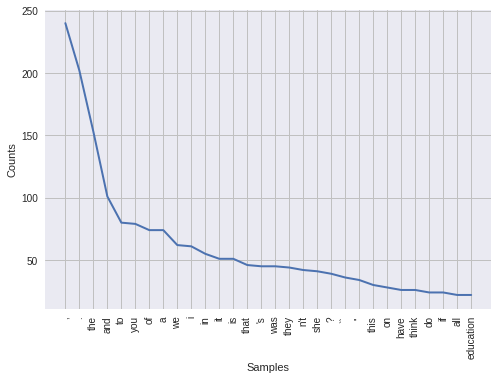

In [24]:
# Plot the distribution! Matplotlib is perhaps the most popular visualization package in Python
fdist.plot(30,cumulative=False)
plt.show()

## Stopwords

The English language contains lots of rather meaningless words that only serve to glue _meaningful_ words together. 

Take the following two sentences, for example:

> _"I was just in Scott, trying to eat, when all the sudden a food fight broke out"_

> _"I was just in the hospital, trying to diagnose a patient, when all the sudden a code blue came over the speaker"_


What's the general topic of each sentence? Do the "glue" words help us determine what the topic is? When we're trying to model topics, these words won't do us any service. So, let's remove them! 

In [25]:
# NLTK has compiled a list of common stopwords that we can remove from our transcripts
stop_words=set(stopwords.words("english"))
print(stop_words)

{'been', 'such', 'through', 'me', 'other', 'did', 'off', 'ma', 'further', 'hers', "didn't", "you've", 'who', 'haven', 'and', 'again', "weren't", 'wouldn', 'which', 'few', 'all', "shan't", 'they', 'while', 'weren', 'same', 'am', 'until', 'wasn', 'between', 'both', 'once', "haven't", 'against', 'myself', 'had', 'in', 'under', 'before', 'does', "wouldn't", 'our', 'after', "won't", 'no', "you're", 'of', 'i', 'its', 'up', 'd', 'more', 'too', "mustn't", 'own', 'this', 'he', 'o', 'their', 'be', 'nor', 'himself', 'if', 'during', 'm', 'not', 'those', 'his', 'an', 'can', "it's", "doesn't", 'are', 'won', "isn't", 'mustn', 'shouldn', 'for', 'some', 'aren', 'mightn', 'most', 'as', 'how', 'have', "aren't", 'doesn', 'these', 't', 'do', 'but', 'over', 'your', 're', 'here', 'only', 'with', 'whom', "mightn't", 'will', 'yourselves', 'themselves', 'because', 'yourself', 'at', 'being', 'having', 'y', 'that', 'to', 'why', 'where', "couldn't", 'itself', "should've", "needn't", 'didn', 'than', 'yours', 'them'

In [0]:
# Remove both stopwords and words with a character length less than 4 from our list of tokens
ted_tokens = [token for token in ted_tokens if token not in stop_words and len(token) > 4]

In [27]:
ted_tokens

['morning',
 'great',
 'blown',
 'whole',
 'thing',
 'leaving',
 'three',
 'themes',
 'running',
 'conference',
 'relevant',
 'extraordinary',
 'evidence',
 'human',
 'creativity',
 'presentations',
 'people',
 'variety',
 'range',
 'second',
 'place',
 'going',
 'happen',
 'terms',
 'future',
 'out.i',
 'interest',
 'education',
 'actually',
 'everybody',
 'interest',
 'education',
 'interesting',
 'dinner',
 'party',
 'education',
 'actually',
 'often',
 'dinner',
 'parties',
 'frankly',
 'education',
 'asked',
 'never',
 'asked',
 'curiously',
 'strange',
 'somebody',
 'education',
 'blood',
 'night',
 'education',
 'things',
 'people',
 'right',
 'religion',
 'money',
 'things',
 'interest',
 'education',
 'think',
 'vested',
 'interest',
 'partly',
 'education',
 'meant',
 'future',
 'grasp',
 'think',
 'children',
 'starting',
 'school',
 'retiring',
 '2065.',
 'nobody',
 'despite',
 'expertise',
 'parade',
 'world',
 'years',
 'meant',
 'educating',
 'unpredictability',
 'think'

## Stemming / Lemmatization

Because of all of the tenses and qualifiers, many of the verbs and nouns in the English language take several different forms, depending on context, but semantically convey the same idea.

Take the verb _break_ for example:

> **Forms:** break, breaks, broke, broken, breaking

Also, take the noun _person_:

> **Forms:** person, people, personification

Because these forms are different on a character by character level, however, a computer will not be able to discern that they are the same without background knowledge. This is where _stemming_ and _lemmatization_ come in. 

_Stemming_ removes common suffixes from words. Stemming will not change the base form of the word.

<br>
![Stemming example](https://nlp.stanford.edu/IR-book/html/htmledition/img102.png)
<br>

_Lemmatization_ involves a full morphilogical analysis to identify the correct _lemma_ (i.e. stem) of each word. It will change the base form of the word if necessary.

In [35]:
# Import and create a Stemmer object
stem = PorterStemmer()

# Import and create a Lemmatizer object
lem = WordNetLemmatizer()


word = "supercalifragilisticexpiallidocious"
print("Stemmed Word:",stem.stem(word))
print("Lemmatized Word:",lem.lemmatize(word,"v"))

Stemmed Word: supercalifragilisticexpiallidoci
Lemmatized Word: supercalifragilisticexpiallidocious


In [33]:
[WordNetLemmatizer().lemmatize(token,"v") for token in ted_tokens]

['morning',
 'great',
 'blow',
 'whole',
 'thing',
 'leave',
 'three',
 'theme',
 'run',
 'conference',
 'relevant',
 'extraordinary',
 'evidence',
 'human',
 'creativity',
 'presentations',
 'people',
 'variety',
 'range',
 'second',
 'place',
 'go',
 'happen',
 'term',
 'future',
 'out.i',
 'interest',
 'education',
 'actually',
 'everybody',
 'interest',
 'education',
 'interest',
 'dinner',
 'party',
 'education',
 'actually',
 'often',
 'dinner',
 'party',
 'frankly',
 'education',
 'ask',
 'never',
 'ask',
 'curiously',
 'strange',
 'somebody',
 'education',
 'blood',
 'night',
 'education',
 'things',
 'people',
 'right',
 'religion',
 'money',
 'things',
 'interest',
 'education',
 'think',
 'vest',
 'interest',
 'partly',
 'education',
 'mean',
 'future',
 'grasp',
 'think',
 'children',
 'start',
 'school',
 'retire',
 '2065.',
 'nobody',
 'despite',
 'expertise',
 'parade',
 'world',
 'years',
 'mean',
 'educate',
 'unpredictability',
 'think',
 'extraordinary.and',
 'third'

## Cleaning up our tokens

Let's apply all the transformation operations to every transcript in the dataset, and save the resulting tokens in a _list of lists_.

In [0]:


# Define a function to do the cleaning for us, given text data and a list of stopwords
def tokenize_and_clean(transcripts):
  
  data = []
  # Apply all cleaning operations to each transcript and append the resulting tokens to a "list of lists"
  for transcript in transcripts:
    ted_tokens = word_tokenize(transcript)
    ted_tokens = [token for token in ted_tokens if token not in stop_words and len(token) > 4]
    ted_tokens = [WordNetLemmatizer().lemmatize(token,"v") for token in ted_tokens]
    data.append(ted_tokens)
    
  return data
  
  
text_data = tokenize_and_clean(ted.transcript)

## Topic Modeling!

Gensim is a _topic modeling framework_, or a suite of tools to convert tokenized data into "corpuses" to be used in _Latent Dirichlet Allocation_, the model to generate topics from transcript tokens.



In [37]:
# Convert the tokens to a dictionary format

dictionary = gensim.corpora.Dictionary(text_data)
dict(dictionary)

{0: '1930s',
 1: '2065.',
 2: 'ability',
 3: 'abstract',
 4: 'academic',
 5: 'academics',
 6: 'accord',
 7: 'achievement',
 8: 'actually',
 9: 'adopt',
 10: 'adults',
 11: 'advice',
 12: 'affection',
 13: 'afford',
 14: 'afterward',
 15: 'agents',
 16: 'agree',
 17: 'alien',
 18: 'allow',
 19: 'along',
 20: 'always',
 21: 'america',
 22: 'andrew',
 23: 'angeles',
 24: 'anniversary',
 25: 'annoy',
 26: 'another',
 27: 'anything',
 28: 'anyway',
 29: 'around',
 30: 'artist',
 31: 'artists',
 32: 'ask',
 33: 'attention',
 34: 'audition',
 35: 'available',
 36: 'avert',
 37: 'aware',
 38: 'ballet',
 39: 'base',
 40: 'be',
 41: 'bear',
 42: 'become',
 43: 'begin',
 44: 'believe',
 45: 'beneath',
 46: 'benign',
 47: 'benignly',
 48: 'better',
 49: 'blood',
 50: 'blow',
 51: 'board',
 52: 'body',
 53: 'bottom',
 54: 'box',
 55: 'brain',
 56: 'break',
 57: 'brilliant',
 58: 'bring',
 59: 'brownie',
 60: 'call',
 61: 'callosum',
 62: 'capacities',
 63: 'capacities.picasso',
 64: 'capacity',
 65

In [38]:
# Create a text "corpus" from each transcript

corpus = [dictionary.doc2bow(text) for text in text_data]
corpus[1870]

[(20, 1),
 (26, 1),
 (29, 1),
 (42, 1),
 (44, 10),
 (58, 1),
 (70, 5),
 (100, 1),
 (138, 1),
 (147, 3),
 (150, 2),
 (151, 1),
 (165, 1),
 (168, 1),
 (187, 5),
 (190, 5),
 (192, 2),
 (195, 4),
 (196, 2),
 (204, 1),
 (217, 3),
 (228, 1),
 (240, 2),
 (241, 1),
 (247, 2),
 (250, 1),
 (256, 2),
 (257, 1),
 (262, 1),
 (270, 1),
 (286, 3),
 (291, 1),
 (312, 11),
 (319, 1),
 (337, 1),
 (353, 6),
 (364, 1),
 (365, 1),
 (371, 6),
 (382, 1),
 (386, 1),
 (402, 4),
 (408, 1),
 (413, 4),
 (418, 1),
 (431, 2),
 (440, 1),
 (446, 1),
 (448, 4),
 (450, 1),
 (497, 2),
 (498, 1),
 (501, 2),
 (514, 2),
 (536, 1),
 (539, 1),
 (585, 1),
 (586, 1),
 (592, 2),
 (624, 2),
 (658, 2),
 (672, 1),
 (697, 2),
 (729, 1),
 (752, 1),
 (781, 1),
 (796, 1),
 (808, 1),
 (827, 1),
 (829, 2),
 (856, 3),
 (881, 3),
 (905, 2),
 (925, 2),
 (935, 1),
 (943, 3),
 (960, 11),
 (1126, 1),
 (1140, 1),
 (1157, 1),
 (1167, 1),
 (1178, 2),
 (1199, 1),
 (1211, 1),
 (1225, 1),
 (1263, 1),
 (1342, 1),
 (1352, 1),
 (1408, 2),
 (1414, 4),
 

In [39]:
# How is the computer interpreting the words?
corpus_1870 = corpus[1870]

for word_id in corpus_1870:
  print("Token {} (\"{}\") appears {} time(s).".format(word_id[0], dictionary[word_id[0]], word_id[1]))



Token 20 ("always") appears 1 time(s).
Token 26 ("another") appears 1 time(s).
Token 29 ("around") appears 1 time(s).
Token 42 ("become") appears 1 time(s).
Token 44 ("believe") appears 10 time(s).
Token 58 ("bring") appears 1 time(s).
Token 70 ("celebrate") appears 5 time(s).
Token 100 ("could") appears 1 time(s).
Token 138 ("education") appears 1 time(s).
Token 147 ("every") appears 3 time(s).
Token 150 ("everything") appears 2 time(s).
Token 151 ("everywhere") appears 1 time(s).
Token 165 ("first") appears 1 time(s).
Token 168 ("follow") appears 1 time(s).
Token 187 ("go") appears 5 time(s).
Token 190 ("great") appears 5 time(s).
Token 192 ("grow") appears 2 time(s).
Token 195 ("happen") appears 4 time(s).
Token 196 ("harder") appears 2 time(s).
Token 204 ("higher") appears 1 time(s).
Token 217 ("important") appears 3 time(s).
Token 228 ("interest") appears 1 time(s).
Token 240 ("learn") appears 2 time(s).
Token 241 ("leave") appears 1 time(s).
Token 247 ("little") appears 2 time(s)

In [0]:
# Let's do LDA!
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)

In [44]:
WORDS_PER_TOPIC = 7
topics = ldamodel.print_topics(num_words = WORDS_PER_TOPIC)
for topic in topics:
    print(topic)


(0, '0.008*"think" + 0.007*"go" + 0.006*"would" + 0.006*"really" + 0.005*"could" + 0.005*"world" + 0.005*"things"')
(1, '0.007*"could" + 0.007*"think" + 0.006*"cancer" + 0.006*"would" + 0.006*"go" + 0.006*"actually" + 0.005*"really"')
(2, '0.013*"people" + 0.011*"think" + 0.009*"would" + 0.008*"really" + 0.008*"go" + 0.007*"could" + 0.007*"start"')
(3, '0.016*"people" + 0.008*"think" + 0.008*"would" + 0.006*"world" + 0.006*"women" + 0.005*"right" + 0.004*"could"')
(4, '0.015*"people" + 0.012*"think" + 0.009*"go" + 0.009*"world" + 0.006*"would" + 0.006*"really" + 0.006*"actually"')


  -

In [0]:
# Create a list of all tokens across transcripts
all_tokens = flatten(text_data)

<FreqDist with 80503 samples and 1655532 outcomes>


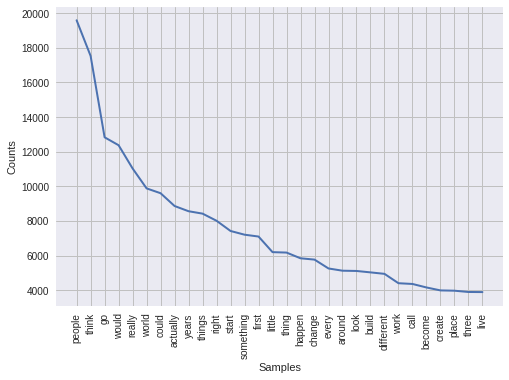

In [46]:
# Create a frequency distribution of all tokens in all transcripts
fdist = FreqDist(all_tokens)
print(fdist)
# Plot the distribution! Matplotlib is perhaps the most popular visualization package in Python
fdist.plot(30,cumulative=False)
plt.show()

In [0]:
# Filter out any tokens that appear in more than 50% of the transcripts
dictionary.filter_extremes(no_above = 0.5)
corpus = [dictionary.doc2bow(text) for text in text_data]


In [0]:
# Retrain the model!
NUM_TOPICS = 5
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)


In [49]:
WORDS_PER_TOPIC = 7
topics = ldamodel.print_topics(num_words = WORDS_PER_TOPIC)
for topic in topics:
    print(topic)


(0, '0.008*"brand" + 0.007*"innovation" + 0.006*"cut" + 0.006*"subject" + 0.005*"despite" + 0.005*"couple" + 0.005*"boot"')
(1, '0.007*"despite" + 0.007*"brand" + 0.006*"palmyra" + 0.006*"cut" + 0.006*"innovation" + 0.006*"adults" + 0.005*"subject"')
(2, '0.013*"retire" + 0.011*"brand" + 0.009*"cut" + 0.008*"subject" + 0.008*"innovation" + 0.007*"despite" + 0.007*"wisely"')
(3, '0.016*"retire" + 0.008*"brand" + 0.008*"cut" + 0.006*"couple" + 0.006*"convince" + 0.005*"thankfully" + 0.004*"despite"')
(4, '0.015*"retire" + 0.012*"brand" + 0.009*"innovation" + 0.009*"couple" + 0.006*"cut" + 0.006*"subject" + 0.006*"adults"')


## Model Evaluation

How is our model generating topic "scores" under the hood? How does it react to transcripts it has never seen before?

In [0]:
# Let's evaulate our model's performance. How is it generating topic "scores" for each transcript?



In [0]:
# How does our model react to a transcript it hasn't seen yet?













In [0]:
# Make sure the tokens look okay before proceeding!


In [0]:
# We'll need to create another corpus for our test transcript


In [0]:
# How does the model perform on test data?



# Resources

> [DataCamp](https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk)

> [AnalyticsVidhya](https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/)

> [Coursera](https://www.coursera.org/learn/python-text-mining)